In [1]:

import numpy as np
import scipy as sp
import h5py
import os

import SimData as sim_data
import Simulator as sim_system
import Optimization as opt

In [2]:


###* Input files and function

reactions_file = "reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                      'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                      'COdb_S': 0.1}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"

In [3]:


def func_optimization(params):
    
    A, B, E = params
    
    nu_d_mod = lambda T: 1e15 * (A + B * np.exp(E/(const_dict['R'] * T)))
    
    dict_mod_vec = [
    {"id": None, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    ]
    
    return dict_mod_vec

loss_function = lambda exp, teo: np.mean((np.reciprocal(exp)*(exp-teo))**2)

exp_file = os.path.join(output_folder_path, exp_data_file)
sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [4]:

if __name__ == '__main__':
    optimizer = opt.Optimizer(sim, func_optimization, loss_function)

    global_bounds = [(1e-5, 1.0), (1e-8, 1.0), (5, 30)]

    config = {
        "bounds": global_bounds,
        "nb_calls": 3, # 5
        "de_maxiter": 10,
        "de_num_iterations": 2,
        "de_max_generations": 50,
        "top_k": 3,
        "local_attempts": 1,
        "epsilon_local": 1e-2
    }
    
    best_local, best_local_loss = optimizer.hybrid_optimization_search(config)


differential_evolution step 1: f(x)= 0.25643834350767336
differential_evolution step 2: f(x)= 0.25643834350767336
differential_evolution step 3: f(x)= 0.21757129714029355
differential_evolution step 4: f(x)= 0.20605497874250756
differential_evolution step 5: f(x)= 0.17996924510272577
differential_evolution step 6: f(x)= 0.1668497808357782
differential_evolution step 7: f(x)= 0.14765994711820554
differential_evolution step 8: f(x)= 0.1392813357254045
differential_evolution step 9: f(x)= 0.1392813357254045
differential_evolution step 10: f(x)= 0.1392813357254045
differential_evolution step 11: f(x)= 0.13788873022753662
differential_evolution step 12: f(x)= 0.13788873022753662
differential_evolution step 13: f(x)= 0.1348380969173489
differential_evolution step 14: f(x)= 0.13144494566302917
differential_evolution step 15: f(x)= 0.1258722330908051
differential_evolution step 16: f(x)= 0.1258722330908051
differential_evolution step 17: f(x)= 0.11303705559212873
differential_evolution step 18

differential_evolution step 50: f(x)= 0.04478092292733615
DE Iteration 1 | False
DE resul: [4.00526137e-04 1.77152969e-03 1.42906487e+01] | 0.04478092292733615
DE:              message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.04478092292733615
                   x: [ 4.005e-04  1.772e-03  1.429e+01]
                 nit: 50
                nfev: 2295
          population: [[ 4.005e-04  1.772e-03  1.429e+01]
                       [ 1.689e-02  2.022e-03  1.386e+01]
                       ...
                       [ 3.094e-03  1.902e-03  1.416e+01]
                       [ 5.833e-03  2.272e-03  1.377e+01]]
 population_energies: [ 4.478e-02  4.903e-02 ...  4.653e-02  5.158e-02]
calls:  2295
itts:  50
differential_evolution step 1: f(x)= 0.26465688445511854
differential_evolution step 2: f(x)= 0.2583364791748256
differential_evolution step 3: f(x)= 0.2583364791748256
differential_evolution step 4: f(x)= 0.2583364791748256
differe

differential_evolution step 38: f(x)= 0.04857258801334414
differential_evolution step 39: f(x)= 0.04795635691317611
differential_evolution step 40: f(x)= 0.047227473762101645
differential_evolution step 41: f(x)= 0.04566328284864269
differential_evolution step 42: f(x)= 0.044756324670911035
differential_evolution step 43: f(x)= 0.044526351318231155
differential_evolution step 44: f(x)= 0.04378848401884505
differential_evolution step 45: f(x)= 0.042275980103466664
differential_evolution step 46: f(x)= 0.042275980103466664
differential_evolution step 47: f(x)= 0.042275980103466664
differential_evolution step 48: f(x)= 0.04184055586667592
differential_evolution step 49: f(x)= 0.04184055586667592


differential_evolution step 50: f(x)= 0.041662857183863554
DE Iteration 2 | False
DE resul: [8.32874763e-03 8.32658918e-04 1.61121534e+01] | 0.041662857183863554
DE:              message: Maximum number of iterations has been exceeded.
             success: False
                 fun: 0.041662857183863554
                   x: [ 8.329e-03  8.327e-04  1.611e+01]
                 nit: 50
                nfev: 2295
          population: [[ 8.329e-03  8.327e-04  1.611e+01]
                       [ 1.505e-02  1.584e-03  1.451e+01]
                       ...
                       [ 2.013e-02  1.580e-03  1.446e+01]
                       [ 1.410e-02  1.325e-03  1.494e+01]]
 population_energies: [ 4.166e-02  4.523e-02 ...  4.616e-02  4.359e-02]
calls:  4590
itts:  100


In [5]:
print(best_local)
print(best_local_loss)

[8.32874763e-03 8.32658918e-04 1.61121534e+01]
0.041662857183863554


In [6]:

# ####* Test default 

import matplotlib.pyplot as plt

params = np.array([0.01634, 1.67e-4, 19.75])



def do_plots(params):


    loss = optimizer.objective_function(params)
    print("PARAMS: ", params, "Loss: ", loss)

    frac_solutions_arr, gammas_results_arr, gammas_sum_arr, gamma_exp_data = optimizer.solve_simulations_updated(params)
    exp_data_arr = optimizer.exp_data_arr

    inv_Tnw_vec = np.array([300/vec['Tnw'] for vec in exp_data_arr])

    plt.figure
    plt.plot(inv_Tnw_vec, gamma_exp_data, '.', label="Exp")
    plt.plot(inv_Tnw_vec, gammas_sum_arr, '.', label="Sim")
    plt.legend()
    plt.xlabel(r"$300/T_{nw}$")
    plt.ylabel(r"$\gamma$")

    current_vec = np.array([vec['current'] for vec in exp_data_arr])
    Tw_vec = np.array([vec['Tw'] for vec in exp_data_arr])

    current_unique = np.unique(current_vec)
    Tw_unique = np.unique([vec['Tw'] for vec in exp_data_arr])


    A, B = np.meshgrid(current_unique, Tw_unique)
    combinations = np.stack([A.ravel(), B.ravel()], axis=1)

    for comb in combinations:
        current = comb[0]
        Tw = comb[1]

        idx_valid = np.logical_and(current_vec == current, Tw_vec == Tw)
        data_arr = exp_data_arr[idx_valid]
        
        pressure_vec = np.array([vec['pressure'] for vec in data_arr])
        gamma_exp = gamma_exp_data[idx_valid]
        gamma_sim = gammas_sum_arr[idx_valid]
        
        plt.figure()
        plt.plot(pressure_vec, gamma_exp*1e4, 's', label="Exp")
        plt.plot(pressure_vec, gamma_sim*1e4, 's', label="Sim")
        plt.title(f"I = {current} and Tw = {Tw}")
        plt.xlabel("Pressure")
        plt.ylabel(r"$\gamma$")
        plt.legend()
        plt.grid()
        plt.ylim(1, 14)
        plt.show()



PARAMS:  [1.634e-02 1.670e-04 1.975e+01] Loss:  0.11222417527210947


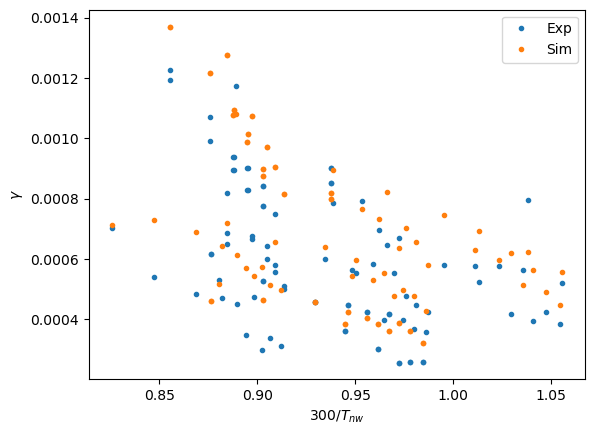

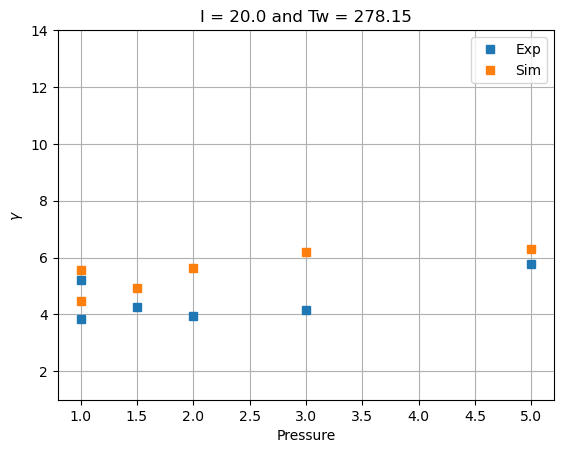

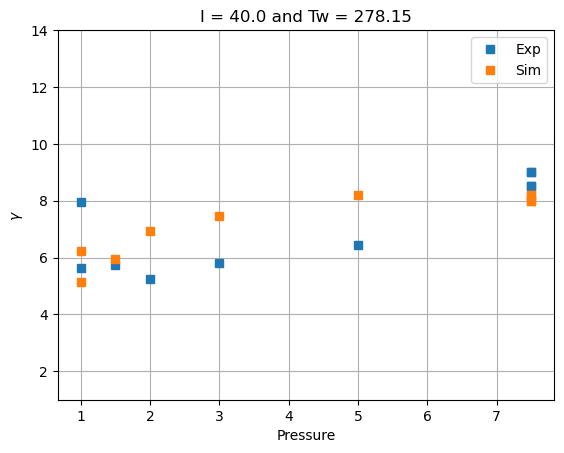

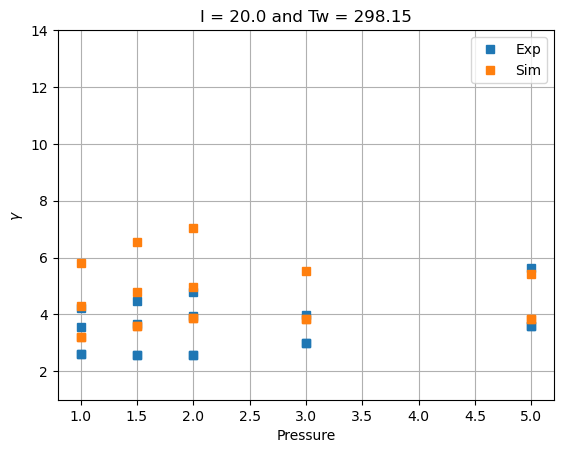

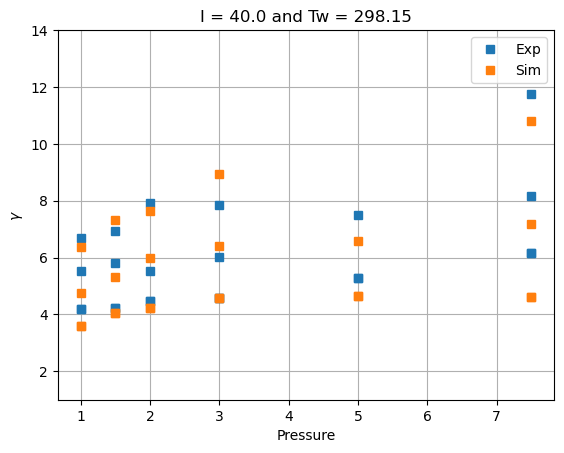

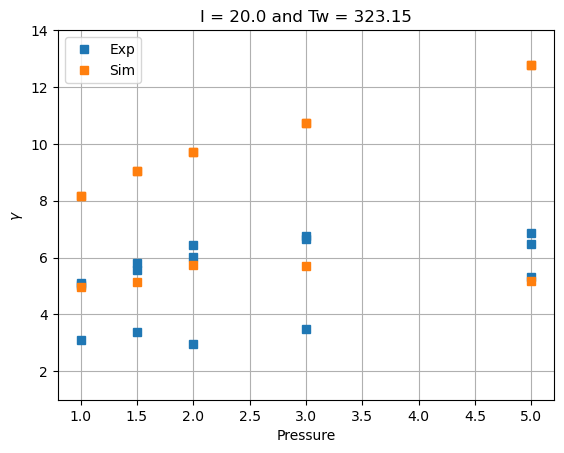

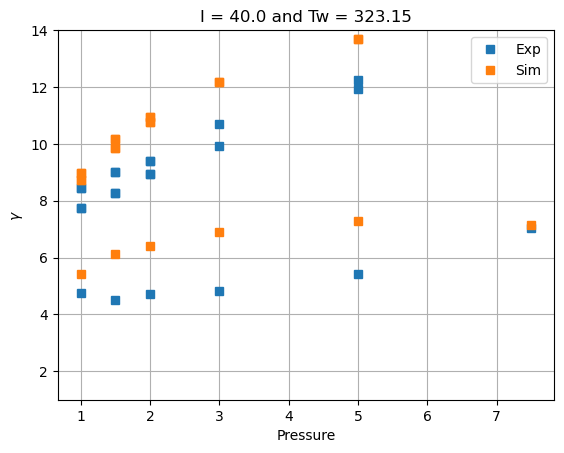

In [7]:

params_1 = np.array([0.01634, 1.67e-4, 19.75])
do_plots(params_1)


PARAMS:  [2.39375716e-02 7.11846527e-04 1.64416626e+01] Loss:  0.04126394421260839


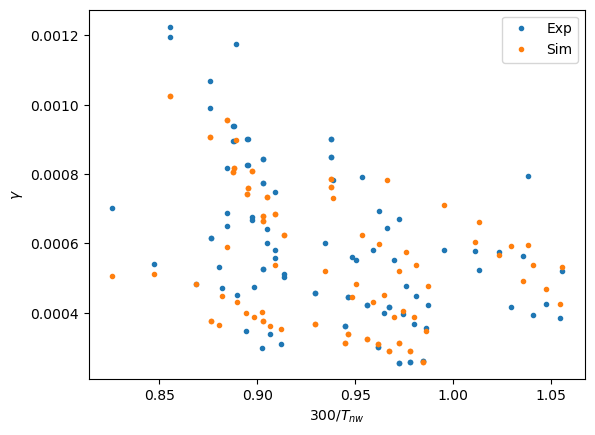

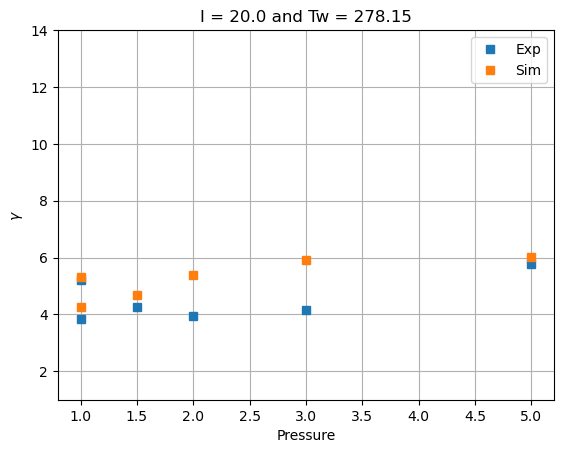

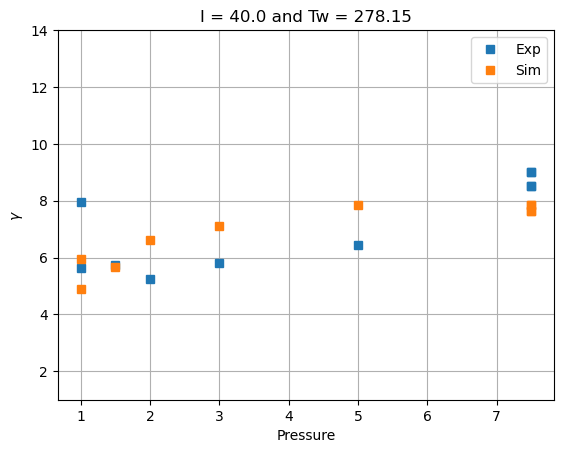

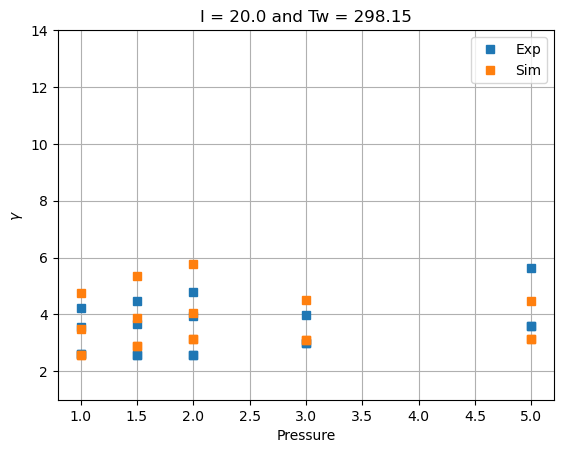

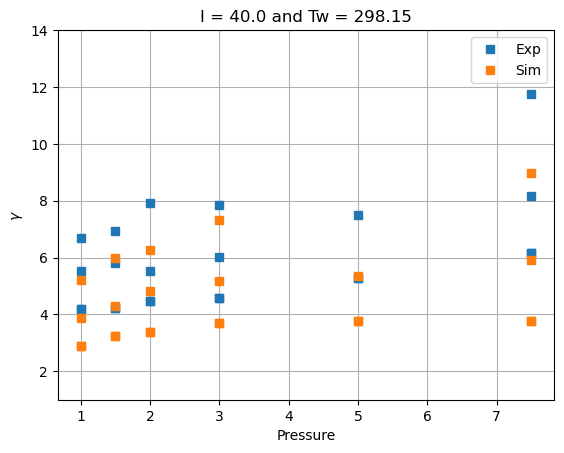

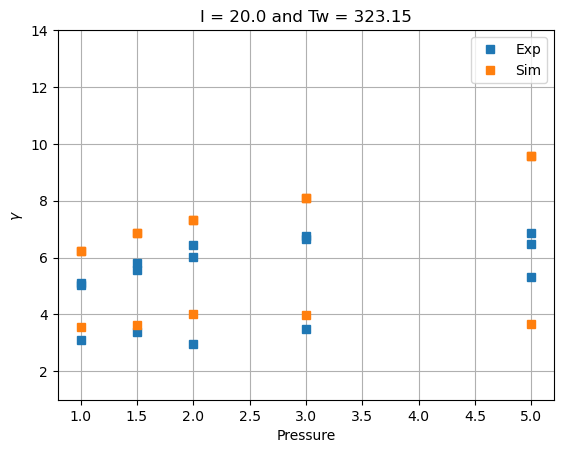

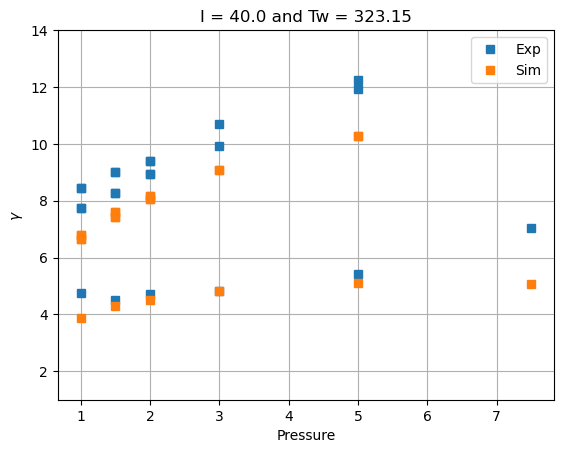

In [8]:





params_2 = np.array([2.39375716e-02, 7.11846527e-04, 1.64416626e+01])
do_plots(params_2)

PARAMS:  [8.32874763e-03 8.32658918e-04 1.61121534e+01] Loss:  0.04166285684118727


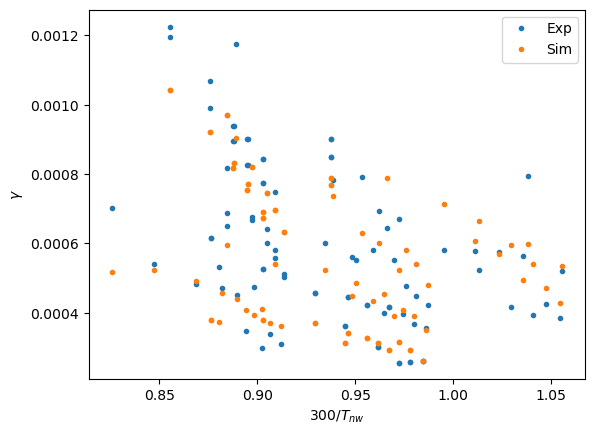

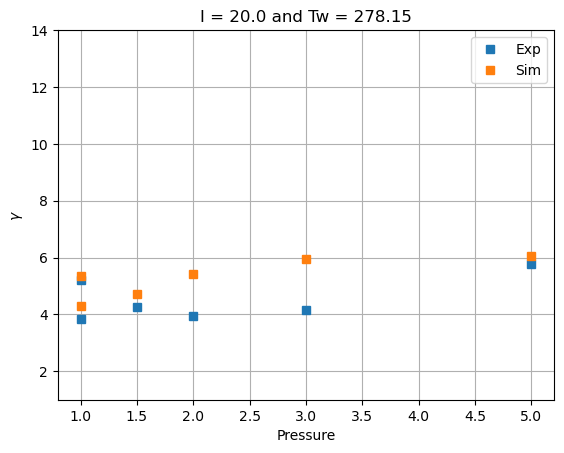

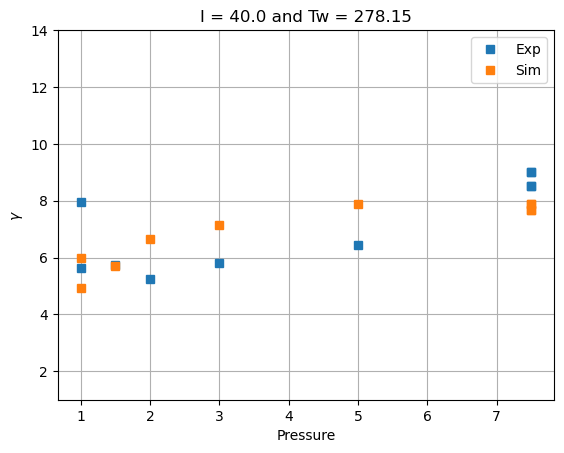

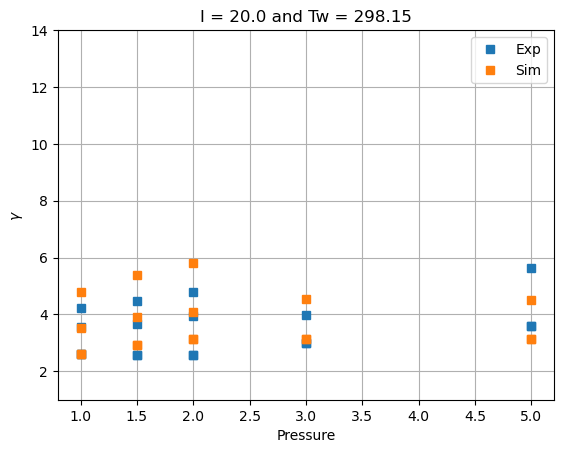

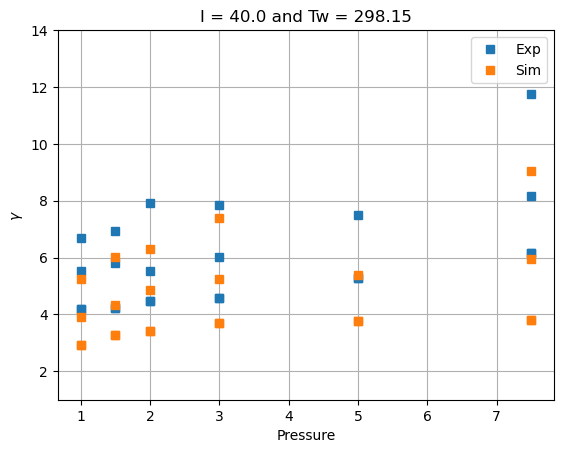

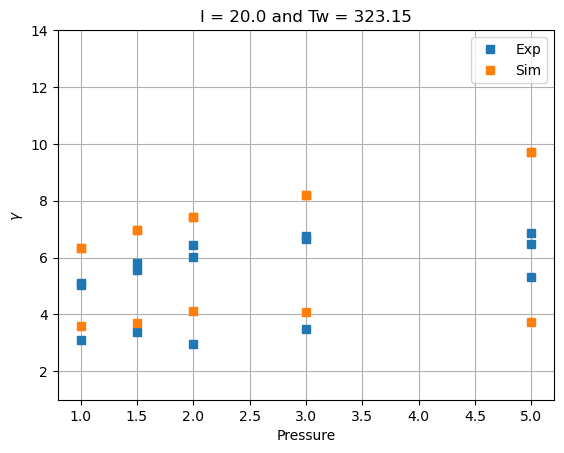

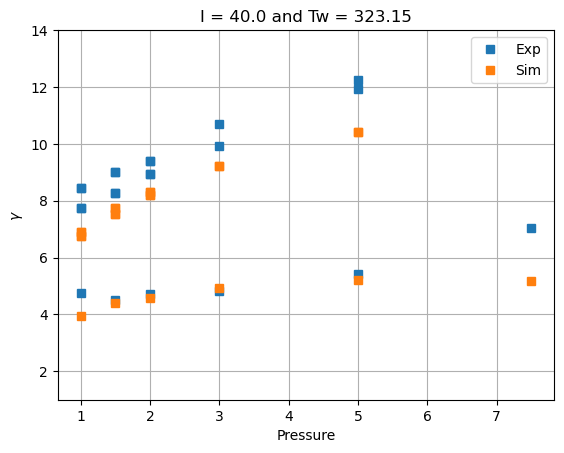

In [10]:

params_3 = np.array([8.32874763e-03, 8.32658918e-04, 1.61121534e+01])
do_plots(params_3)

Text(0, 0.5, '$\\nu_{d}$')

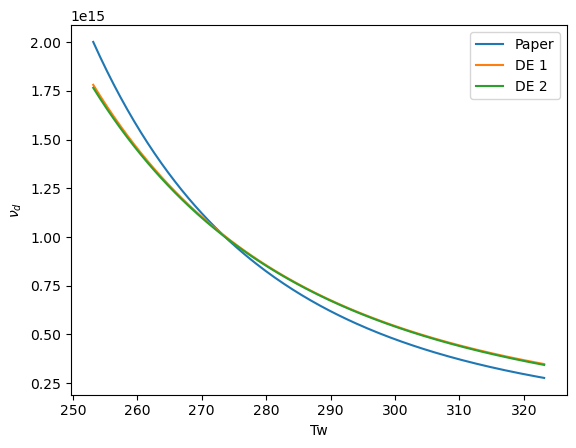

In [11]:

def nu_d_func(T, params):
    A, B, E = params
    
    nu_d_mod = 1e15 * (A + B * np.exp(E * np.reciprocal(const_dict['R'] * T)))
    
    return nu_d_mod


T_space = np.linspace(-20+273.15, 50+273.15, 200)

vec_1 = np.array([nu_d_func(T, params_1) for T in T_space])
vec_2 = np.array([nu_d_func(T, params_2) for T in T_space])
vec_3 = np.array([nu_d_func(T, params_3) for T in T_space])

plt.plot(T_space, vec_1, label="Paper")
plt.plot(T_space, vec_2, label="DE 1")
plt.plot(T_space, vec_3, label="DE 2")
plt.legend()
plt.xlabel("Tw")
plt.ylabel(r"$\nu_{d}$")